### This notebook trains a neural network to perform multistep forecasts

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

Using the logistic equation to generate timeseries data

In [4]:
def logisticEq(r, x0, N):
    x = [x0]
    for i in range(1, N):
        x_new = r * x[i-1] * (1 - x[i-1])
        x.append(x_new)
    return np.array(x)

Generate the sample data. It is necessary to add a dimension to the data to define a sequence.

In [5]:
samples = np.arange(0, 10000)

r = 4
x0 = 0.3
N = len(samples)

data = logisticEq(r=r, x0=x0, N = N) * 5
data = np.expand_dims(data, axis=1) # add dimension to define 1D data

Functions to embed the data and plot for visualization of the phase portrait

In [7]:
def TDE(x, m, tau):
    emb = np.zeros((len(x)-m*tau, m))
    for i in range(m):
        emb[:,i] = x[i*tau:(i*tau + (len(x)-m*tau))]
    return emb

In [6]:
def statespaceplot(x):
    fig = plt.figure()
    fig.set_size_inches(8, 10)
    if x.shape[1] > 2:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], alpha=0.7)
    else:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], alpha=0.7)
    ax.set_title('State Space')
    ax.set_xlabel("X")
    ax.set_ylabel("X'")
    ax.set_zlabel('X"')
    plt.show()

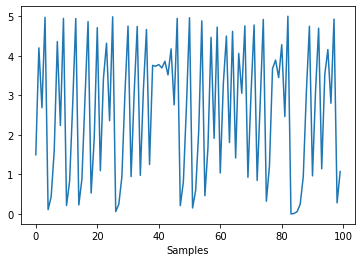

In [8]:
plt.plot(samples[:100], data[:100])
plt.xlabel("Samples")
plt.show()

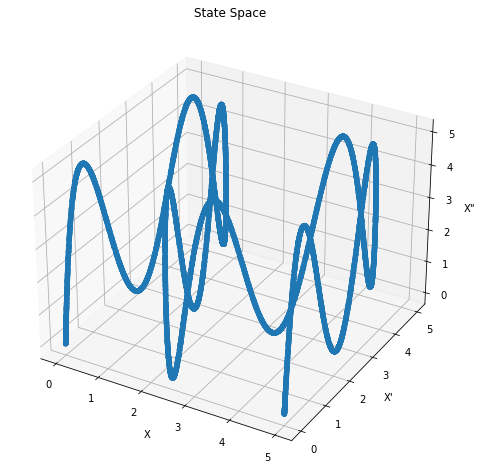

In [9]:
tde_data = TDE(data.squeeze(), m=3, tau=2)
statespaceplot(tde_data)

To prevent vanishing/expoding gradients we scale the data before into the network. StandardScaler (x - mean / std) or MinMaxScaler ((x - min) / (max - min)) work well. This is crucial for multivariate datasets.
  
We are using MinMaxScaler 

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Now a more difficult problem would likely be to forecast the next 10 samples, rather than the next sample.

We window our dataset below to create a dataset to do this.

In [11]:
window_size = 32
forecast_size = 10

x = []
y = []
for i in range(window_size, scaled_data.shape[0]-forecast_size):
    x.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i:i+forecast_size])

x = np.array(x)
y = np.array(y)

Split the data into training and validation

In [12]:
cutoff = round(0.8 * x.shape[0])

x_train = x[:cutoff]
y_train = y[:cutoff]

x_val = x[cutoff:]
y_val = y[cutoff:]

print("Training Inputs Shape:", x_train.shape)
print("Training Outputs Shape:", y_train.shape)

print("\nValidation Inputs Shape:", x_val.shape)
print("Validation Outputs Shape:", y_val.shape)

Training Inputs Shape: (7966, 32, 1)
Training Outputs Shape: (7966, 10, 1)

Validation Inputs Shape: (1992, 32, 1)
Validation Outputs Shape: (1992, 10, 1)


In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Building a seq2seq LSTM autoencoder below. A pretty good model for complex sequence modelling tasks.

In [15]:
inputs = Input(shape=(None, x.shape[-1]))

h = LSTM(16, return_sequences=True)(inputs)
h = LSTM(16, return_sequences=False)(h)
h = RepeatVector(forecast_size)(h)

h = LSTM(16, return_sequences=True)(h)
h = LSTM(16, return_sequences=True)(h)

outputs = TimeDistributed(Dense(1))(h)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            2112      
                                                                 
 lstm_3 (LSTM)               (None, 10, 16)            2112      
                                                             

Compile and train the model

In [21]:
optimizer = Adam(learning_rate=1e-3)
loss = 'mse'
model.compile(loss=loss, optimizer=optimizer)

In [22]:
history = model.fit(x_train,y_train,
            validation_data=(x_val,y_val),
            epochs=20,
            shuffle=True,
            batch_size=32,
            verbose=1)

Epoch 1/20


2023-01-24 23:12:09.466935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.046845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.192084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.313520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.395914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.592581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:10.673615: I tensorflow/core/grappler/optimizers/cust

  3/249 [..............................] - ETA: 8s - loss: 0.1259   

2023-01-24 23:12:10.867043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - ETA: 0s - loss: 0.1244

2023-01-24 23:12:19.280334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:19.478384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:19.541265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:19.606972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:12:19.647734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 14s 39ms/step - loss: 0.1244 - val_loss: 0.1253
Epoch 2/20
249/249 [==============================] - 8s 30ms/step - loss: 0.1243 - val_loss: 0.1255
Epoch 3/20
249/249 [==============================] - 7s 30ms/step - loss: 0.1243 - val_loss: 0.1254
Epoch 4/20
249/249 [==============================] - 8s 30ms/step - loss: 0.1243 - val_loss: 0.1254
Epoch 5/20
249/249 [==============================] - 7s 29ms/step - loss: 0.1243 - val_loss: 0.1256
Epoch 6/20
249/249 [==============================] - 7s 30ms/step - loss: 0.1243 - val_loss: 0.1254
Epoch 7/20
249/249 [==============================] - 8s 31ms/step - loss: 0.1243 - val_loss: 0.1254
Epoch 8/20
249/249 [==============================] - 8s 30ms/step - loss: 0.1243 - val_loss: 0.1257
Epoch 9/20
249/249 [==============================] - 8s 31ms/step - loss: 0.1242 - val_loss: 0.1257
Epoch 10/20
249/249 [==============================] - 8s 30ms/step - loss: 0.1242 - val_loss: 0.1253

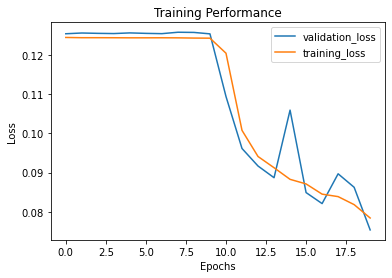

In [23]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate the validation dataset

In [24]:
y_pred = model.predict(x_val, batch_size=32)

2023-01-24 23:14:47.333114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:14:47.547264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:14:47.615463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:14:47.688163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-24 23:14:47.734327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Now we will flatten the 3D sequences for our validation dataset/predictions, so we can convert the data back to the original scale (sklearn scalers require 2D arrays). 

In [25]:
y_val2 = np.expand_dims(y_val.ravel(), axis=1)
y_val2 = scaler.inverse_transform(y_val2)

x_val2 = np.expand_dims(x_val.ravel(), axis=1)
x_val2 = scaler.inverse_transform(x_val2)

y_pred2 = np.expand_dims(y_pred.ravel(), axis=1)
y_pred2 = scaler.inverse_transform(y_pred2)

Next we will reshape the arrays back into their 3D form to plot

In [27]:
x_val2 = x_val2.reshape((1992,32,1))
y_val2 = y_val2.reshape((1992,10,1))
y_pred2 = y_pred2.reshape((1992,10,1))

Calculate the rmse and plot for predictions vs. ground truth

RMSE = 1.3728630703354492


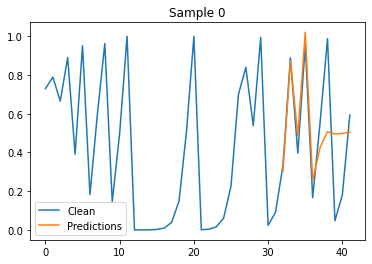

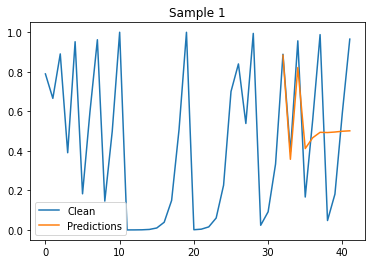

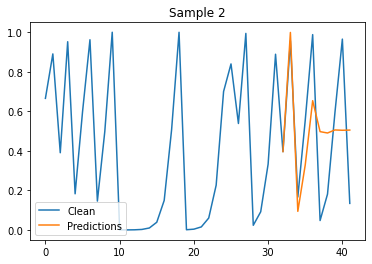

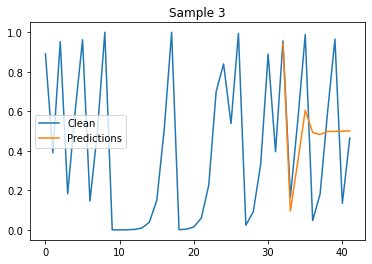

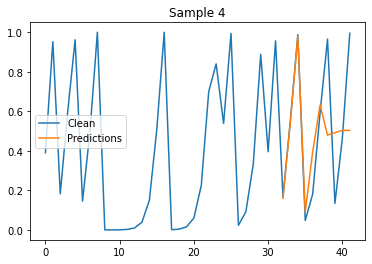

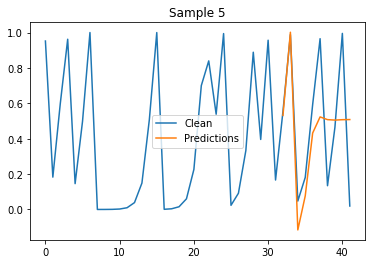

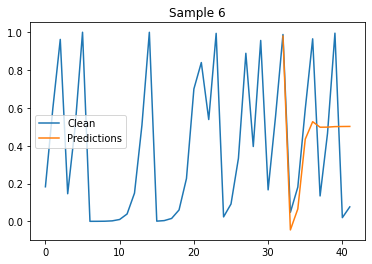

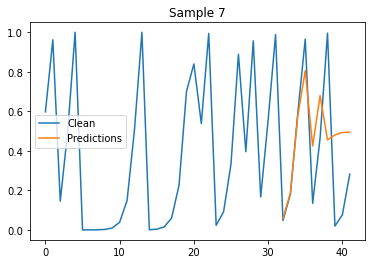

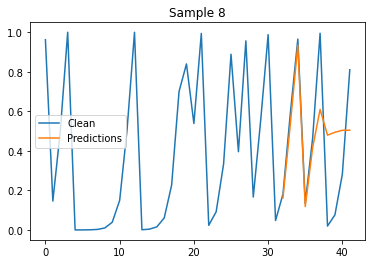

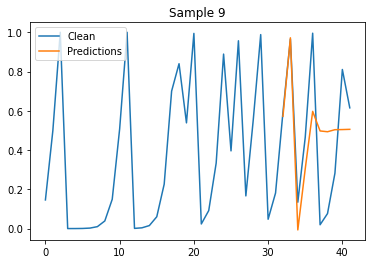

In [28]:
rmse = np.sqrt( np.mean( (y_val2 - y_pred2)**2 ) )
print("RMSE =", rmse)

for i in range(10):
    t = np.arange(42)
    raw_data = np.concatenate([x_val[i], y_val[i]], axis=0)
    plt.plot(t, raw_data)
    plt.plot(t[-10:], y_pred[i])
    plt.legend(['Ground Truth', 'Predictions'])
    plt.title("Sample " + str(i))
    plt.show()